In [21]:
import os

import numpy as np

import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform
from nengo.params import Default
from nengo.utils.numpy import rmse

from nengolib.signal import s, nrmse, LinearSystem
from nengolib.synapses import Lowpass

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from scipy.signal import convolve

from nengo_bioneurons import BahlNeuron

# Signals

In [22]:
def make_stimulus(signal, freq, amp, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: np.sin(freq*t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=amp,
            seed=seed))

In [23]:
def norms(signal, freq, amp, ss, tau, t, plot=False):
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = make_stimulus(signal, freq, amp, ss)
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    
    if plot:
        plt.plot(sim.trange(), stimulus)
        plt.plot(sim.trange(), target)
        plt.plot(sim.trange(), lpf.filt(sim.data[p_integral]/norm_f))
        plt.show()
    return norm, norm_s, norm_f

In [24]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1,
    x_max=1,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

# Encoder Learning

In [25]:
class EncoderNode(nengo.Node):
    def __init__(
            self,
            conn,
            n_bio,
            n_syn,
            dim,
            d_pre,
            eta,  # learning rate
            seed, # learning seed
            syn_encoders_init):
        
        self.conn = conn
        self.n_syn = n_syn
        self.dim = dim
        self.d_pre = d_pre
        self.eta = eta
        self.rng = np.random.RandomState(seed=seed)
        self.n_pre = self.d_pre.shape[0]
        self.n_bio = n_bio
        self.syn_encoders = syn_encoders_init
        self.syn_weights = np.zeros_like(self.syn_encoders)
        self.a_target = np.array([])
        self.a_bio = np.array([])

        super(EncoderNode, self).__init__(self.update, 
            size_in=2*self.n_bio,  # [a_bio, a_lif]
            size_out=self.n_bio)

    def update(self, t, x):
        self.a_bio = x[0:self.n_bio]
        self.a_target = x[self.n_bio:2*self.n_bio]
        return self.a_bio - self.a_target
    
    def update_encoders(self, bio, pre, syn):
        a_error = self.a_bio[bio] - self.a_target[bio]
        d_syn = self.d_pre[pre]
        e_old = self.syn_encoders[bio, pre, syn]
        delta = self.rng.uniform(0, 2 * self.eta * np.abs(a_error))
        if a_error > 0 and d_syn > 0:  # overactive, positive dec => reduce enc reduce weight
            self.syn_encoders[bio, pre, syn] += -delta
        if a_error > 0 and d_syn < 0:  # overactive, negative dec => increase enc reduce weight
            self.syn_encoders[bio, pre, syn] += +delta
        if a_error < 0 and d_syn > 0:  # underactive, positive dec => increase enc increase weight
            self.syn_encoders[bio, pre, syn] += +delta
        if a_error < 0 and d_syn < 0:  # underactive, negative dec => reduce enc increase weight
            self.syn_encoders[bio, pre, syn] += -delta
        w_new = np.dot(d_syn, self.syn_encoders[bio, pre, syn])
        return w_new

    def update_weights(self):
        for bio in range(self.n_bio):
            for pre in range(self.n_pre):
                for syn in range(self.n_syn):
                    self.syn_weights[bio, pre, syn] = np.dot(self.d_pre[pre], self.syn_encoders[bio, pre, syn])
        return self.syn_weights

# Readout Filter and Decoder Optimization

In [26]:
def optimize_elephys(
    save_data,
    n_neurons,
    tau_lpf,
    n_zeros=0,
    n_poles=1,
    z_min=-1e0,
    z_max=1e0,
    p_min=-1e-1,
    p_max=5e-1,
    reg=0.1,
    max_evals=100,
    normalize=True,
    seed=5):
    
    h_eps = []
    hyps = {}  # hyperparameters
    hyps['save_data'] = save_data
    for bio in range(n_neurons):  # put all bios in one hyperparams so decoder act on all 
        for z in range(n_zeros):
            hyps['%s_bio_%s_zero'%(bio, z)] = hp.uniform('%s_bio_%s_zero'%(bio, z), z_min, z_max)
        for p in range(n_poles):
            hyps['%s_bio_%s_pole'%(bio, p)] = hp.uniform('%s_bio_%s_pole'%(bio, p), p_min, p_max)


    def objective(hyps):
        from nengolib.signal import nrmse
        from nengo.utils.numpy import rmse

        for bio in range(n_neurons):
            zeros = np.array([hyps['%s_bio_%s_zero'%(bio, z)] for z in range(n_zeros)])
            poles = np.array([hyps['%s_bio_%s_pole'%(bio, p)] for p in range(n_poles)])
            h_ep = LinearSystem((zeros, poles, 1.0))
            if normalize:
                h_ep/= h_ep.dcgain
            h_eps.append(h_ep)
                
        spikes = np.load(hyps['save_data'])['spikes']
        act_lpf = nengo.Lowpass(tau_lpf).filt(spikes)
        act_eps = np.zeros_like(act_lpf)
        for n in range(n_neurons):
            act_eps[:,n] = h_eps[n].filt(act_lpf[:,n])
        target = np.load(hyps['save_data'])['target']
        if np.sum(act_eps != 0):
            d_eps = nengo.solvers.LstsqL2(reg=reg)(act_eps, target)[0]
        else:
            d_eps = np.zeros((n_neurons, 1))
        xhat_eps = np.dot(act_eps, d_eps)
        if np.sum(target) != 0: nrmse = nrmse(xhat_eps, target=target)
        else: nrmse = rmse(xhat_eps, target)

        return {'loss': nrmse,
            'h_eps': h_eps,
            'd_eps': d_eps,
            'status': STATUS_OK }

    trials = Trials()

    best = fmin(objective,
                rstate=np.random.RandomState(seed=seed),
                space=hyps,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best_idx = np.array(trials.losses()).argmin()
    best_h_eps = trials.trials[best_idx]['result']['h_eps']
    best_d_eps = trials.trials[best_idx]['result']['d_eps']

    return best_h_eps, best_d_eps

## Helper

In [27]:
def get_kwargs(
    n_neurons=10,
    n_syn=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed')):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    lif_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'],
        label='lif')
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syn,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=Uniform(-1, 1),
        gain=Uniform(0, 0),
        bias=Uniform(0, 0),
        neuron_type=neuron_type,
        seed=seeds['es'],
        label='bio')
    
    return pre_kwargs, lif_kwargs, conn_kwargs, bio_kwargs

In [28]:
def get_syn_encoders_init(
    n_neurons=10,
    n_syn=1,
    signal='cos',
    freq=1,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed')):

    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t)
    pre_kwargs, lif_kwargs, conn_kwargs, bio_kwargs = get_kwargs(n_neurons, n_syn, sec, taus, seeds, neuron_type)

    # Build a network to collect encoders, gains, biases from target LIF
    with nengo.Network(seed=seeds['ns']) as pre_model:
        pre_u = nengo.Ensemble(radius=norm_s, **pre_kwargs)
        pre_x = nengo.Ensemble(radius=norm, **pre_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)
        pre_u_lif = nengo.Connection(pre_u, lif, **conn_kwargs)
        pre_x_lif = nengo.Connection(pre_x, lif, **conn_kwargs)
    sim = nengo.Simulator(pre_model, seed=seeds['ss'])
    d_pre_u = sim.data[pre_u_lif].weights.T
    d_pre_x = sim.data[pre_x_lif].weights.T
    e_target = sim.data[lif].encoders
    syn_encoders_init = np.zeros((n_neurons, 100, n_syn))
    for bio in range(syn_encoders_init.shape[0]):
        syn_encoders_init[bio] = e_target[bio] * np.ones((100, n_syn))
        
    return syn_encoders_init, d_pre_u, d_pre_x

# Network

In [29]:
def bio_fb_double_opt(
    d_pre_u,
    d_pre_x,    
    d_eps_bio,
    d_eps_supv,
    h_eps_bio,
    h_eps_supv,
    syn_weights_pre_u_supv,
    syn_weights_pre_x_supv,
    syn_weights_pre_u_bio,
    syn_weights_supv_bio,
    syn_weights_bio_bio,
    syn_encoders_pre_u_supv,
    syn_encoders_pre_x_supv,
    syn_encoders_pre_u_bio,
    syn_encoders_supv_bio,
    syn_encoders_bio_bio,
    t=1,
    n_neurons=10,
    n_syn=1,
    signal='cos',
    freq=1,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed'),
    save_dir='/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/double_optimize_zeropole_biofb/',
    save_file_bio='bio.npz',
    save_file_supv='supv.npz',
    eta=0,
    n_zeros=0,
    n_poles=1,
    z_min=-1e0,
    z_max=1e0,
    p_min=-1e-1,
    p_max=-1e-2,
    learn_supv=True,
    learn_bio=True,
    learn_fb=True,
    optimize_supv=True,
    optimize_bio=True,
    plot_supv=True,
    plot_bio=True,
    sim_supv=True,
    sim_bio=True):
    
    # transform input signal u so that the integral x is normalized to np.max(x)==1
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t)
    # keyword arguments for ensembles and connections
    pre_kwargs, lif_kwargs, conn_kwargs, bio_kwargs = get_kwargs(n_neurons, n_syn, sec, taus, seeds, neuron_type)

    
    # Simulate the full network with encoder learning rules. Skip simulating supv or bio when possible.
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seed=seeds['ss'])
        pre_u = nengo.Ensemble(radius=norm_s, **pre_kwargs)
        pre_x = nengo.Ensemble(radius=norm, **pre_kwargs)
        if sim_supv: supv = nengo.Ensemble(**bio_kwargs)
        if sim_bio: bio = nengo.Ensemble(**bio_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # normal connections
        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_f)
        nengo.Connection(pre_u, lif, synapse=taus['network'], transform=taus['network']/norm_f)
        lif_lif = nengo.Connection(lif, lif, **conn_kwargs)
        
        # bioneuron connections (learned)
        if sim_supv:
            pre_u_supv = nengo.Connection(pre_u, supv, syn_weights=syn_weights_pre_u_supv, **conn_kwargs)
            pre_x_supv = nengo.Connection(pre_x, supv, syn_weights=syn_weights_pre_x_supv, **conn_kwargs)
        if sim_bio:
            pre_u_bio = nengo.Connection(pre_u, bio, syn_weights=syn_weights_pre_u_bio, **conn_kwargs)
            bio_bio = nengo.Connection(bio, bio, syn_weights=syn_weights_bio_bio, **conn_kwargs)
        if sim_supv and sim_bio:
            supv_bio = nengo.Connection(supv, bio, syn_weights=syn_weights_supv_bio, **conn_kwargs)
  
        # associate encoder learning nodes with each learned connection
        if learn_supv and sim_supv:
            enc_node_pre_u_supv = EncoderNode(
                pre_u_supv, n_neurons, n_syn, 1, d_pre_u, eta, seeds['ls'], syn_encoders_pre_u_supv)
            enc_node_pre_x_supv = EncoderNode(
                pre_x_supv, n_neurons, n_syn, 1, d_pre_x, eta, seeds['ls'], syn_encoders_pre_x_supv)
            pre_u_supv.learning_node = enc_node_pre_u_supv
            pre_x_supv.learning_node = enc_node_pre_x_supv
            nengo.Connection(supv.neurons, enc_node_pre_u_supv[0:n_neurons], synapse=taus['readout'])
            nengo.Connection(lif.neurons, enc_node_pre_u_supv[n_neurons:2*n_neurons], synapse=taus['readout'])
            nengo.Connection(supv.neurons, enc_node_pre_x_supv[0:n_neurons], synapse=taus['readout'])
            nengo.Connection(lif.neurons, enc_node_pre_x_supv[n_neurons:2*n_neurons], synapse=taus['readout'])
            
        if learn_bio and sim_bio:
            enc_node_pre_u_bio = EncoderNode(
                pre_u_bio, n_neurons, n_syn, 1, d_pre_u, eta, seeds['ls'], syn_encoders_pre_u_bio)
            enc_node_supv_bio = EncoderNode(
                supv_bio, n_neurons, n_syn, 1, d_eps_supv, eta, seeds['ls'], syn_encoders_supv_bio)
            pre_u_bio.learning_node = enc_node_pre_u_bio
            supv_bio.learning_node = enc_node_supv_bio
            nengo.Connection(bio.neurons, enc_node_pre_u_bio[0:n_neurons], synapse=taus['readout'])
            nengo.Connection(lif.neurons, enc_node_pre_u_bio[n_neurons:2*n_neurons], synapse=taus['readout'])
            nengo.Connection(bio.neurons, enc_node_supv_bio[0:n_neurons], synapse=taus['readout'])
            nengo.Connection(lif.neurons, enc_node_supv_bio[n_neurons:2*n_neurons], synapse=taus['readout'])
            
        if learn_fb and sim_bio:
            enc_node_bio_bio = EncoderNode(
                bio_bio, n_neurons, n_syn, 1, d_eps_bio, eta, seeds['ls'], syn_encoders_bio_bio)
            bio_bio.learning_node = enc_node_bio_bio
            nengo.Connection(bio.neurons, enc_node_bio_bio[0:n_neurons], synapse=taus['readout'])
            nengo.Connection(lif.neurons, enc_node_bio_bio[n_neurons:2*n_neurons], synapse=taus['readout'])

        # probes
        p_stim = nengo.Probe(u, synapse=None)
        p_target = nengo.Probe(tar, synapse=None)
        if sim_supv:
            p_spk_supv = nengo.Probe(supv.neurons, synapse=None)
            p_act_supv = nengo.Probe(supv.neurons, synapse=taus['readout'])
        if sim_bio:
            p_spk_bio = nengo.Probe(bio.neurons, synapse=None)
            p_act_bio = nengo.Probe(bio.neurons, synapse=taus['readout'])
        p_act_lif = nengo.Probe(lif.neurons, synapse=taus['readout'])
        p_lif = nengo.Probe(lif, synapse=taus['readout'])
#         p_lpf = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_lpf))
#         p_lpf2 = nengo.Probe(bio2, synapse=taus['readout'], solver=NoSolver(d_lpf2))

    # RUN the simulation
    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    # collect spikes, lowpass activities, and lif decodes
    lpf = nengo.Lowpass(taus['readout'])
    stim = lpf.filt(sim.data[p_stim])
    target = lpf.filt(sim.data[p_target])
    if sim_supv:
        spikes_supv = sim.data[p_spk_supv]
        act_lpf_supv = sim.data[p_act_supv]
    if sim_bio:
        spikes_bio = sim.data[p_spk_bio]
        act_lpf_bio = sim.data[p_act_bio]
    act_lif = sim.data[p_act_lif]
    xhat_lif = sim.data[p_lif]
    nrmse_lif = nrmse(xhat_lif, target=target)
#     xhat_lpf = sim.data[p_lpf]
#     xhat_lpf2 = sim.data[p_lpf2]
#     nrmse_lpf = nrmse(xhat_lpf, target=target)
#     nrmse_lpf2 = nrmse(xhat_lpf2, target=target2)
    
    # optimize d_eps and h_eps given spikes and a target
    if optimize_supv and sim_supv:
        np.savez(save_dir+save_file_supv, spikes=spikes_supv, target=target)
        h_eps_supv, d_eps_supv = optimize_elephys(
            save_dir+save_file_supv,
            n_neurons,
            taus['readout'],
            n_zeros=n_zeros,
            n_poles=n_poles,
            z_min=z_min,
            z_max=z_max,
            p_min=p_min,
            p_max=p_max,
            reg=regs['bio-out'],
            max_evals=max_evals,
            normalize=True,
            seed=seeds['ls'])
        
    if optimize_bio and sim_bio:
        np.savez(save_dir+save_file_bio, spikes=spikes_bio, target=target)
        h_eps_bio, d_eps_bio = optimize_elephys(
            save_dir+save_file_bio,
            n_neurons,
            taus['readout'],
            n_zeros=n_zeros,
            n_poles=n_poles,
            z_min=z_min,
            z_max=z_max,
            p_min=p_min,
            p_max=p_max,
            reg=regs['bio-out'],
            max_evals=max_evals,
            normalize=True,
            seed=seeds['ls'])

    # Compute activities and xhat from h_eps and d_eps, then bin data for tuning curve estimation
    act_eps_supv = np.zeros_like(act_lif)
    act_eps_bio = np.zeros_like(act_lif)
    x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(
        target, act_lif, n_neurons=n_neurons)
    if sim_supv:
        for n in range(n_neurons):
            act_eps_supv[:,n] = h_eps_supv[n].filt(act_lpf_supv[:,n])
        xhat_eps_supv = np.dot(act_eps_supv, d_eps_supv)
        nrmse_eps_supv = nrmse(xhat_eps_supv, target=target)
        x_bins_eps_supv, hz_means_eps_supv, hz_stds_eps_supv = bin_activities_values_1d(
            target, act_eps_supv, n_neurons=n_neurons)
    if sim_bio:
        for n in range(n_neurons):
            act_eps_bio[:,n] = h_eps_bio[n].filt(act_lpf_bio[:,n])
        xhat_eps_bio = np.dot(act_eps_bio, d_eps_bio)
        nrmse_eps_bio = nrmse(xhat_eps_bio, target=target)
        x_bins_eps_bio, hz_means_eps_bio, hz_stds_eps_bio = bin_activities_values_1d(
            target, act_eps_bio, n_neurons=n_neurons)

    # Plots
    if plot_supv and sim_supv:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        rasterplot(sim.trange(), spikes_supv, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_lpf_supv), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency', title='supv')
        
        times = np.arange(0, 1, 0.001)
        fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        ax.plot(times, Lowpass(taus['readout']).impulse(len(times)))
        for n in range(n_neurons):
            ax2.plot(times, h_eps_supv[n].impulse(len(times)))
            ax3.plot(times, h_eps_supv[n].filt(Lowpass(taus['readout']).impulse(len(times))))
        ax.set(xlabel='time', ylabel='amplitude', title='lowpass')
        ax2.set(xlabel='time', title='h_eps_supv')
        ax3.set(xlabel='time', title='h_eps_supv.filt(lowpass)')
        plt.tight_layout()
        
        cmap = sns.color_palette('hls', n_neurons)
        fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
        for n in range(n_neurons):
            ax4.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
            ax4.fill_between(x_bins_lif,
                hz_means_lif[n]+hz_stds_lif[n],
                hz_means_lif[n]-hz_stds_lif[n],
                alpha=0.5, facecolor=cmap[n])
            ax5.plot(x_bins_eps_supv, hz_means_eps_supv[n], c=cmap[n])
            ax5.fill_between(x_bins_eps_supv,
                hz_means_eps_supv[n]+hz_stds_eps_supv[n],
                hz_means_eps_supv[n]-hz_stds_eps_supv[n],
                alpha=0.5, facecolor=cmap[n])
        ax4.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='lif')
        ax5.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', title='elephys supv')
        plt.tight_layout()
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(sim.trange(), target, label='target', linestyle='--')
        ax.plot(sim.trange(), xhat_lif, alpha=0.5, label='lif, nrmse=%.3f' %nrmse_lif)
        ax.plot(sim.trange(), xhat_eps_supv, alpha=0.5, label='elephys, nrmse=%.3f' %nrmse_eps_supv)
        ax.set(xlabel='time', ylabel='$\mathbf{x}$', title='supv')
        ax.legend(loc='lower left')
        plt.tight_layout()
        
        plt.show()

    if plot_bio and sim_bio:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        rasterplot(sim.trange(), spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_lpf_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency', title='bio')
        
        times = np.arange(0, 1, 0.001)
        fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        ax.plot(times, Lowpass(taus['readout']).impulse(len(times)))
        for n in range(n_neurons):
            ax2.plot(times, h_eps_bio[n].impulse(len(times)))
            ax3.plot(times, h_eps_bio[n].filt(Lowpass(taus['readout']).impulse(len(times))))
        ax.set(xlabel='time', ylabel='amplitude', title='lowpass')
        ax2.set(xlabel='time', title='h_eps_bio')
        ax3.set(xlabel='time', title='h_eps_bio.filt(lowpass)')
        plt.tight_layout()
        
        cmap = sns.color_palette('hls', n_neurons)
        fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
        for n in range(n_neurons):
            ax4.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
            ax4.fill_between(x_bins_lif,
                hz_means_lif[n]+hz_stds_lif[n],
                hz_means_lif[n]-hz_stds_lif[n],
                alpha=0.5, facecolor=cmap[n])
            ax5.plot(x_bins_eps_bio, hz_means_eps_bio[n], c=cmap[n])
            ax5.fill_between(x_bins_eps_bio,
                hz_means_eps_bio[n]+hz_stds_eps_bio[n],
                hz_means_eps_bio[n]-hz_stds_eps_bio[n],
                alpha=0.5, facecolor=cmap[n])
        ax4.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='lif')
        ax5.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', title='elephys bio')
        plt.tight_layout()
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(sim.trange(), target, label='target', linestyle='--')
        ax.plot(sim.trange(), xhat_lif, alpha=0.5, label='lif, nrmse=%.3f' %nrmse_lif)
        ax.plot(sim.trange(), xhat_eps_bio, alpha=0.5, label='elephys, nrmse=%.3f' %nrmse_eps_bio)
        ax.set(xlabel='time', ylabel='$\mathbf{x}$', title='bio')
        ax.legend(loc='lower left')
        plt.tight_layout()
        
        plt.show()

    # Update synaptic weights for any connection that has been simulated
    if sim_supv:
        syn_weights_pre_u_supv_new = sim.data[pre_u_supv].weights
        syn_weights_pre_x_supv_new = sim.data[pre_x_supv].weights
    else:
        syn_weights_pre_u_supv_new = syn_weights_pre_u_supv
        syn_weights_pre_x_supv_new = syn_weights_pre_x_supv
    if sim_bio:
        syn_weights_pre_u_bio_new = sim.data[pre_u_bio].weights
        syn_weights_bio_bio_new = sim.data[bio_bio].weights
    else:
        syn_weights_pre_u_bio_new = syn_weights_pre_u_bio
        syn_weights_bio_bio_new = syn_weights_bio_bio
    if sim_supv and sim_bio:
        syn_weights_supv_bio_new = sim.data[supv_bio].weights
    else:
        syn_weights_supv_bio_new = syn_weights_supv_bio

    # Update synaptic encoders for any connection that has been learned
    if learn_supv:
        syn_encoders_pre_u_supv_new = enc_node_pre_u_supv.syn_encoders
        syn_encoders_pre_x_supv_new = enc_node_pre_x_supv.syn_encoders
    else:
        syn_encoders_pre_u_supv_new = syn_encoders_pre_u_supv
        syn_encoders_pre_x_supv_new = syn_encoders_pre_x_supv
    if learn_bio:
        syn_encoders_pre_u_bio_new = enc_node_pre_u_bio.syn_encoders
        syn_encoders_supv_bio_new = enc_node_supv_bio.syn_encoders
    else:
        syn_encoders_pre_u_bio_new = syn_encoders_pre_u_bio
        syn_encoders_supv_bio_new = syn_encoders_supv_bio
    if learn_fb:
        syn_encoders_bio_bio_new = enc_node_bio_bio.syn_encoders
    else:
        syn_encoders_bio_bio_new = syn_encoders_bio_bio
    
    # Return dictionary of filters, decoders, encoders, and weights
    h_eps_new = {'h_eps_supv': h_eps_supv, 'h_eps_bio': h_eps_bio}
    d_eps_new = {'d_eps_supv': d_eps_supv, 'd_eps_bio': d_eps_bio}
    syn_encoders_new = {
        'syn_encoders_pre_u_supv': syn_encoders_pre_u_supv_new,
        'syn_encoders_pre_x_supv': syn_encoders_pre_x_supv_new,
        'syn_encoders_pre_u_bio': syn_encoders_pre_u_bio_new,
        'syn_encoders_supv_bio': syn_encoders_supv_bio_new,
        'syn_encoders_bio_bio': syn_encoders_bio_bio_new,
        }
    syn_weights_new = {
        'syn_weights_pre_u_supv': syn_weights_pre_u_supv_new,
        'syn_weights_pre_x_supv': syn_weights_pre_x_supv_new,
        'syn_weights_pre_u_bio': syn_weights_pre_u_bio_new,
        'syn_weights_supv_bio': syn_weights_supv_bio_new,
        'syn_weights_bio_bio': syn_weights_bio_bio_new,
        }
    return h_eps_new, d_eps_new, syn_encoders_new, syn_weights_new

# Simulations

### Train supv and bio such that the supvervised simulation results in aligned tuning curves and state representations

Moderate time, moderate learning rate, moderate freq

Building finished in 0:00:01.                                                   
training supervisor
Building finished in 0:00:01.                                                   
Simulating finished in 0:11:27.                                                 


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  9.21555400e-01  -1.04473346e+00]
 [  9.60334419e-04   9.99470522e-01]], B=[[  9.60334419e-04]
 [  4.86703779e-07]], C=[[   -9.09944586  1074.97193485]], D=[[ 0.01186993]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.83393492e-01  -3.36476147e+00]
 [  9.40790578e-04   9.98282870e-01]], B=[[  9.40790578e-04]
 [  4.80111233e-07]], C=[[  -37.2710201   3426.32207898]], D=[[ 0.04199702]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.84726801e-01  -3.29857516e+00]
 [  9.41479393e-04   9.98317061e-01]], B=[[  9.41479393e-04]
 [  4.80344580e-07]], C=[[  -19.98198407  3428.30636719]], D=[[ 0.02149272]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.63094504e-01  -4.25637921e+00]
 [  9.30249880e-04   9.97819620e-01]], B=[[  9.30249880e-04]
 [  4.76531470e-07]], C=[[  -33.70037353  4421.02305268]], D=[[ 0.0337665]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/n

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  9.74180084e-01  -1.41565790e-01]
 [  9.87045710e-04   9.99928909e-01]], B=[[  9.87045710e-04]
 [  4.95674500e-07]], C=[[  -7.69796502  139.20865635]], D=[[ 0.02938904]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.60433425e-01  -5.01783899e+00]
 [  9.28919820e-04   9.97428266e-01]], B=[[  9.28919820e-04]
 [  4.76088317e-07]], C=[[  -99.34882939  4444.3527165 ]], D=[[ 0.17724595]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/ne

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  9.36763693e-01  -8.72275411e-01]
 [  9.68112734e-04   9.99559114e-01]], B=[[  9.68112734e-04]
 [  4.89325847e-07]], C=[[  -7.84553674  890.09786604]], D=[[ 0.01210665]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.72956608e-01  -3.64388780e+00]
 [  9.35365275e-04   9.98136820e-01]], B=[[  9.35365275e-04]
 [  4.78267792e-07]], C=[[  -21.08975141  3814.53501391]], D=[[ 0.02083056]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/ne

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.47468813e-01  -6.04399380e+00]
 [  9.22178734e-04   9.96894714e-01]], B=[[  9.22178734e-04]
 [  4.73797486e-07]], C=[[  -18.43053947  6485.43485496]], D=[[ 0.0104672]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.64267653e-01  -4.31007493e+00]
 [  9.30870746e-04   9.97792601e-01]], B=[[  9.30870746e-04]
 [  4.76744255e-07]], C=[[  -89.58884669  3727.79319299]], D=[[ 0.19488786]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/n

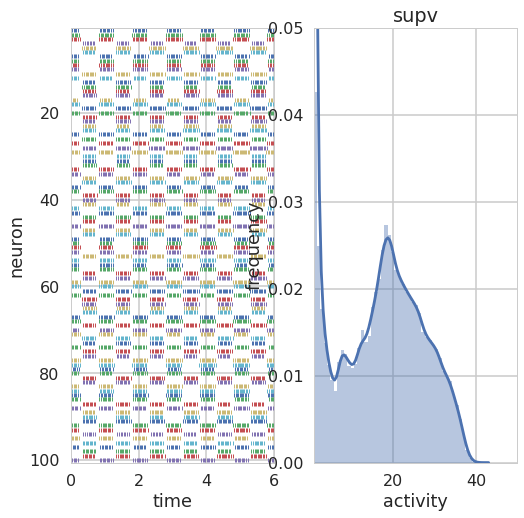

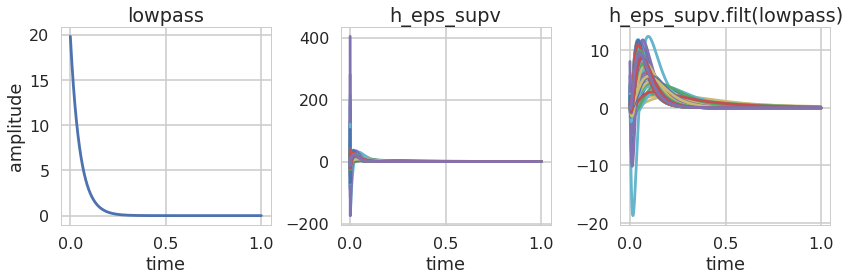

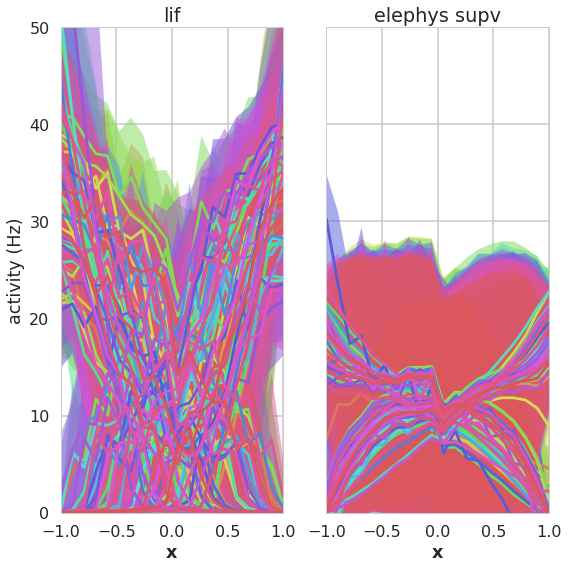

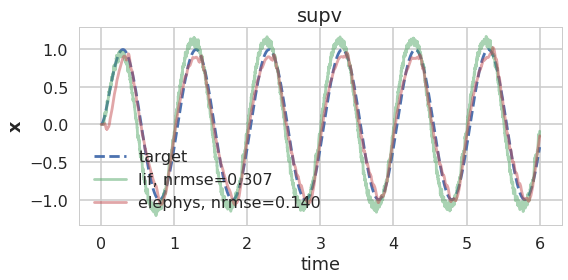

training bio
Building finished in 0:00:02.                                                   
Simulating finished in 0:26:07.                                                 


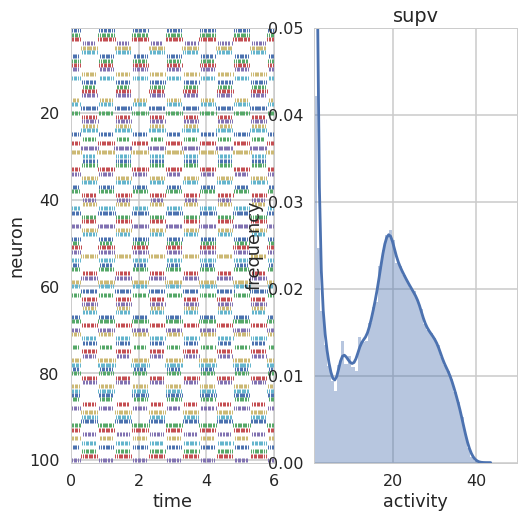

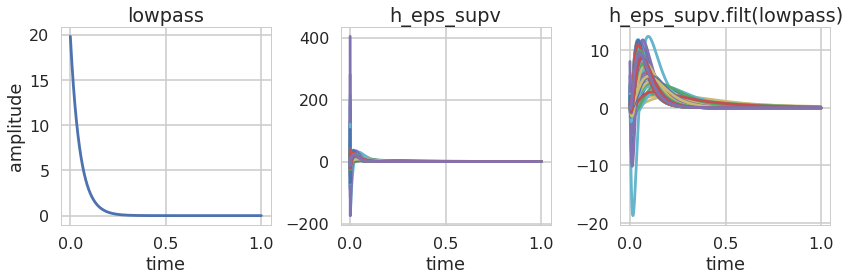

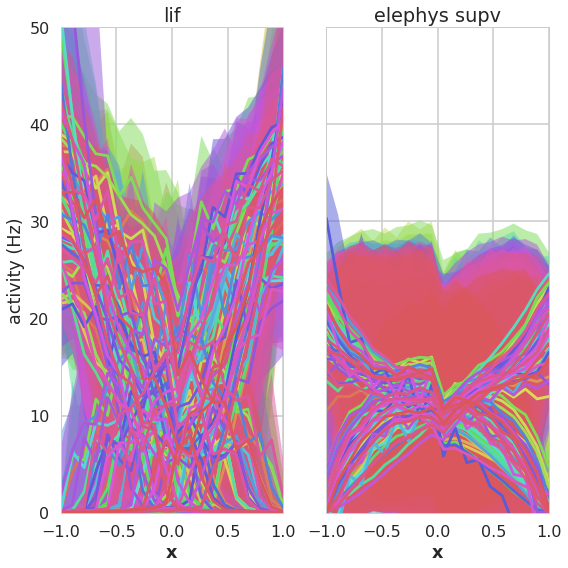

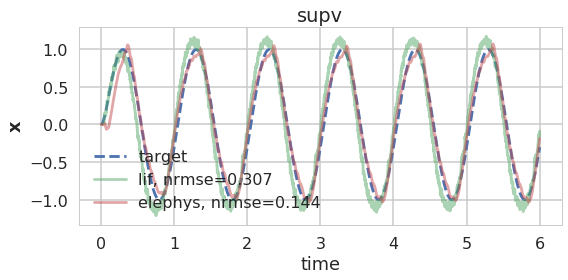

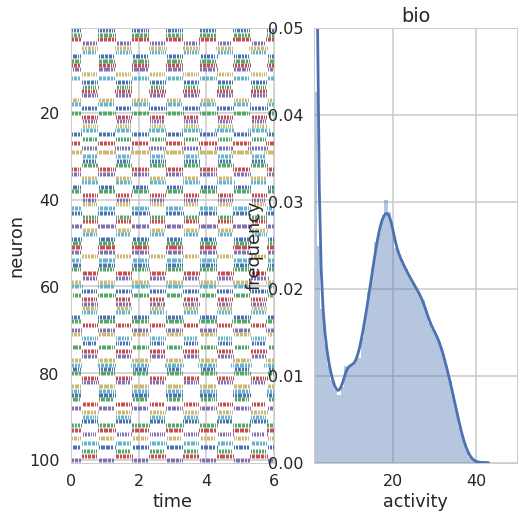

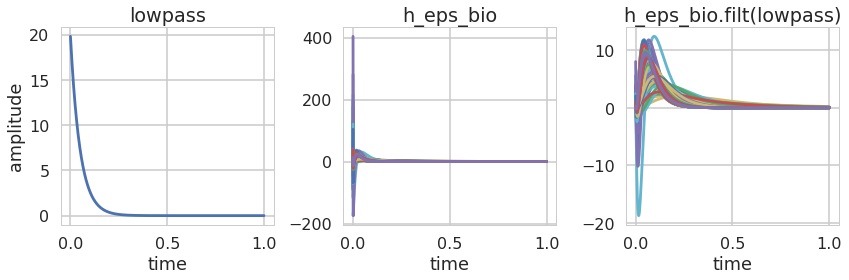

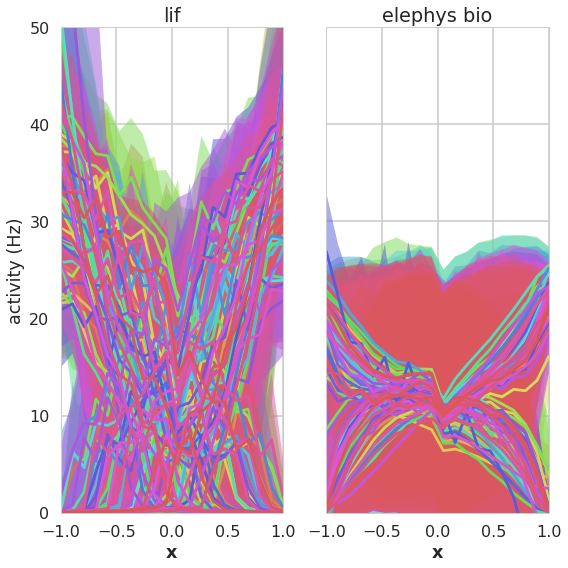

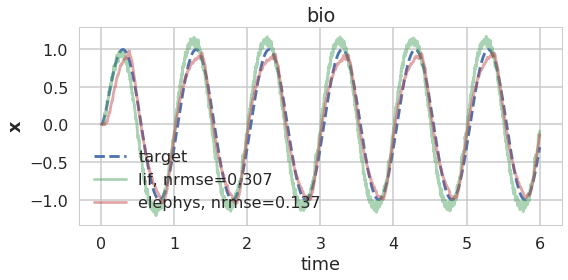

In [32]:
n_neurons = 100
max_evals = 100
n_syn = 1
t = 6
freq = 2*np.pi
eta = 2e-4

save_dir='/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/double_optimize_polezero_biofb/' + \
    '%s_neurons_%s_evals_%s_nsyn_%s_time_%.3f_freq_%s_eta/' %(n_neurons, max_evals, n_syn, t, freq, eta)
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_file_supv='supv.npz'
save_file_bio='bio.npz'
    
d_eps_bio = np.zeros((n_neurons, 1))
d_eps_supv = np.zeros((n_neurons, 1))
h_eps_bio = []
h_eps_supv = []

syn_weights_pre_u_supv = np.zeros((n_neurons, 100, n_syn))
syn_weights_pre_x_supv = np.zeros((n_neurons, 100, n_syn))
syn_weights_pre_u_bio = np.zeros((n_neurons, 100, n_syn))
syn_weights_supv_bio = np.zeros((n_neurons, 100, n_syn))
syn_weights_bio_bio = np.zeros((n_neurons, 100, n_syn))

syn_encoders_init, d_pre_u, d_pre_x = get_syn_encoders_init(n_neurons, n_syn, freq=freq,
    taus={'network': 0.05, 'readout': 0.05},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed'))

syn_encoders_pre_u_supv = syn_encoders_init
syn_encoders_pre_x_supv = syn_encoders_init
syn_encoders_pre_u_bio = syn_encoders_init
syn_encoders_supv_bio = syn_encoders_init
syn_encoders_bio_bio = syn_encoders_init


print "training supervisor"
h_eps_dict, d_eps_dict, syn_encoders_dict, syn_weights_dict = bio_fb_double_opt(
    d_pre_u,
    d_pre_x,    
    d_eps_bio,
    d_eps_supv,
    h_eps_bio,
    h_eps_supv,
    syn_weights_pre_u_supv,
    syn_weights_pre_x_supv,
    syn_weights_pre_u_bio,
    syn_weights_supv_bio,
    syn_weights_bio_bio,
    syn_encoders_pre_u_supv,
    syn_encoders_pre_x_supv,
    syn_encoders_pre_u_bio,
    syn_encoders_supv_bio,
    syn_encoders_bio_bio,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    save_dir=save_dir,
    save_file_supv=save_file_supv,
    save_file_bio=save_file_bio,
    eta=eta,
    n_zeros=2,
    n_poles=2,
    z_min=1e1,
    z_max=1e3,
    p_min=-1e2,
    p_max=-1e0,
    learn_supv=True,
    learn_bio=False,
    learn_fb=False,
    optimize_supv=True,
    optimize_bio=False,
    plot_supv=True,
    plot_bio=False,
    sim_supv=True,
    sim_bio=False)

print "training bio"
h_eps_dict, d_eps_dict, syn_encoders_dict, syn_weights_dict = bio_fb_double_opt(
    d_pre_u,
    d_pre_x,    
    d_eps_dict['d_eps_bio'],
    d_eps_dict['d_eps_supv'],
    h_eps_dict['h_eps_bio'],
    h_eps_dict['h_eps_supv'],
    syn_weights_dict['syn_weights_pre_u_supv'],
    syn_weights_dict['syn_weights_pre_x_supv'],
    syn_weights_dict['syn_weights_pre_u_bio'],
    syn_weights_dict['syn_weights_supv_bio'],
    syn_weights_dict['syn_weights_bio_bio'],
    syn_encoders_dict['syn_encoders_pre_u_supv'],
    syn_encoders_dict['syn_encoders_pre_x_supv'],
    syn_encoders_dict['syn_encoders_pre_u_bio'],
    syn_encoders_dict['syn_encoders_supv_bio'],
    syn_encoders_dict['syn_encoders_bio_bio'],
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    save_dir=save_dir,
    save_file_supv=save_file_supv,
    save_file_bio=save_file_bio,
    eta=eta,
    n_zeros=2,
    n_poles=2,
    z_min=1e1,
    z_max=1e3,
    p_min=-1e2,
    p_max=-1e0,
    learn_supv=False,
    learn_bio=True,
    learn_fb=False,
    optimize_supv=False,
    optimize_bio=True,
    plot_supv=True,
    plot_bio=True,
    sim_supv=True,
    sim_bio=True)

np.savez(save_dir+'decoders.npz',
    d_pre_u=d_pre_u,
    d_pre_x=d_pre_x,    
    d_eps_bio=d_eps_dict['d_eps_bio'],
    d_eps_supv=d_eps_dict['d_eps_supv'])

np.savez(save_dir+'syn_weights.npz',
    syn_weights_pre_u_supv=syn_weights_dict['syn_weights_pre_u_supv'],
    syn_weights_pre_x_supv=syn_weights_dict['syn_weights_pre_x_supv'],
    syn_weights_pre_u_bio=syn_weights_dict['syn_weights_pre_u_bio'],
    syn_weights_supv_bio=syn_weights_dict['syn_weights_supv_bio'],
    syn_weights_bio_bio=syn_weights_dict['syn_weights_bio_bio'])

np.savez(save_dir+'syn_encoders.npz',
    syn_encoders_pre_u_supv=syn_encoders_dict['syn_encoders_pre_u_supv'],
    syn_encoders_pre_x_supv=syn_encoders_dict['syn_encoders_pre_x_supv'],
    syn_encoders_pre_u_bio=syn_encoders_dict['syn_encoders_pre_u_bio'],
    syn_encoders_supv_bio=syn_encoders_dict['syn_encoders_supv_bio'],
    syn_encoders_bio_bio=syn_encoders_dict['syn_encoders_bio_bio'])

h_eps_bio_num = [np.array(filt.num) for filt in h_eps_dict['h_eps_bio']]
h_eps_bio_den = [np.array(filt.den) for filt in h_eps_dict['h_eps_bio']]
h_eps_supv_num = [np.array(filt.num) for filt in h_eps_dict['h_eps_supv']]
h_eps_supv_den = [np.array(filt.den) for filt in h_eps_dict['h_eps_supv']]

np.savez(save_dir+'filters.npz',
    h_eps_bio_num=h_eps_bio_num,
    h_eps_bio_den=h_eps_bio_den,
    h_eps_supv_num=h_eps_supv_num,
    h_eps_supv_den=h_eps_supv_den)

training fb
Building finished in 0:00:01.                                                   
Simulating finished in 0:10:22.                                                 


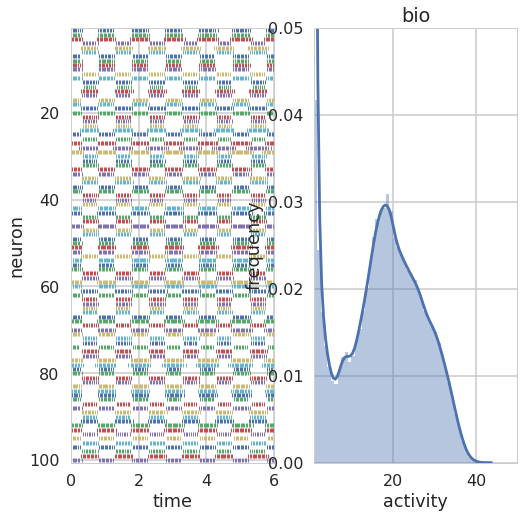

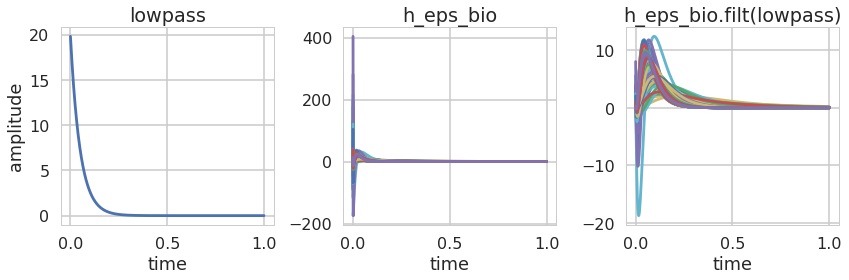

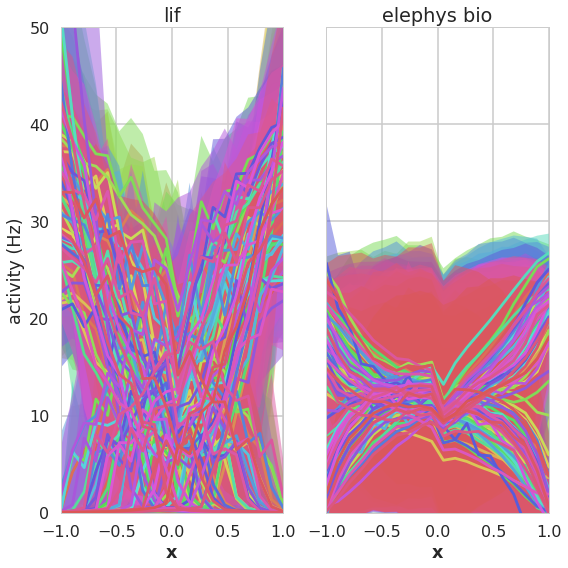

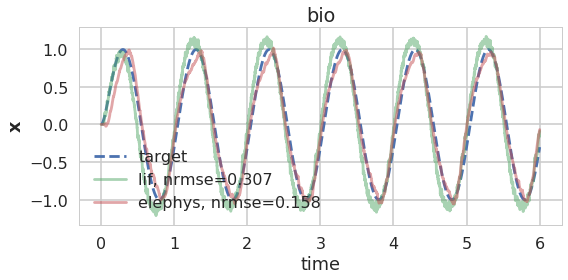

testing
Building finished in 0:00:01.                                                   
Simulating finished in 0:11:11.                                                 


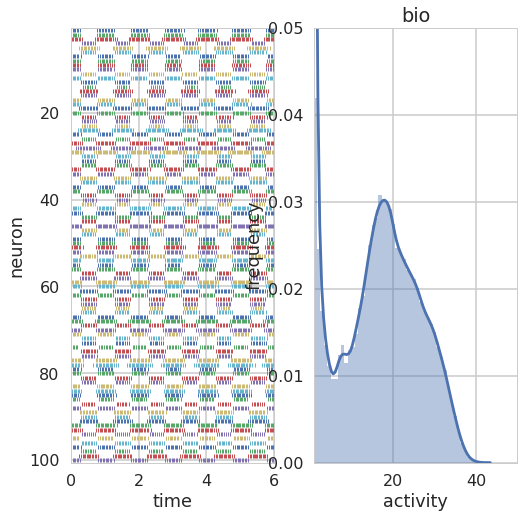

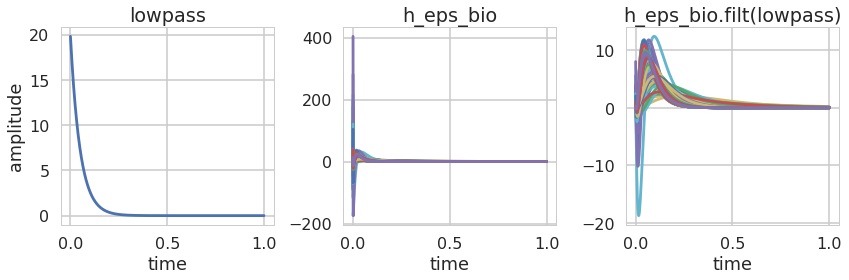

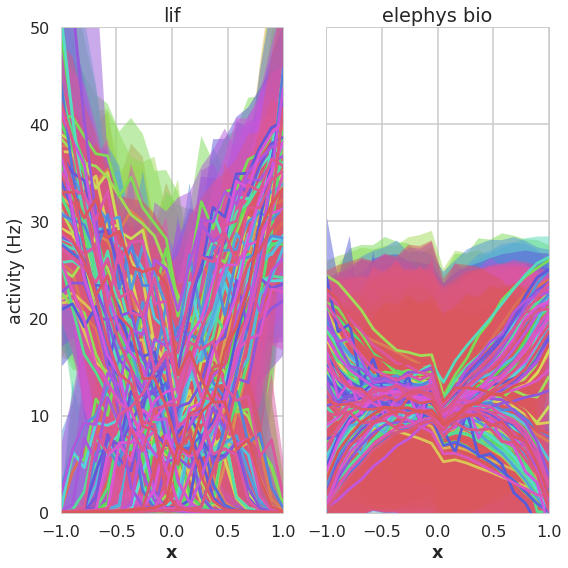

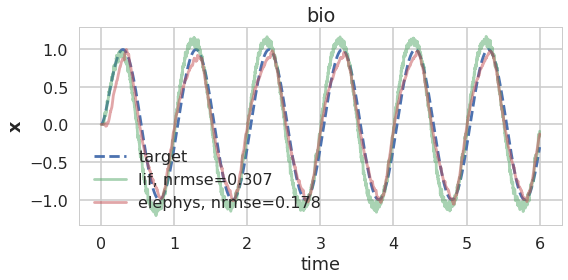

testing
Building finished in 0:00:01.                                                   
Simulating finished in 0:07:58.                                                 


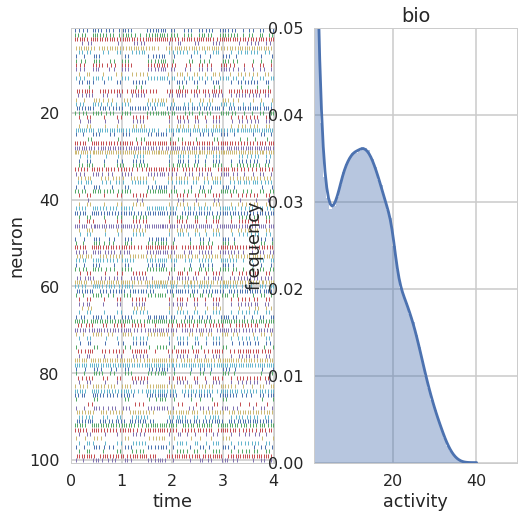

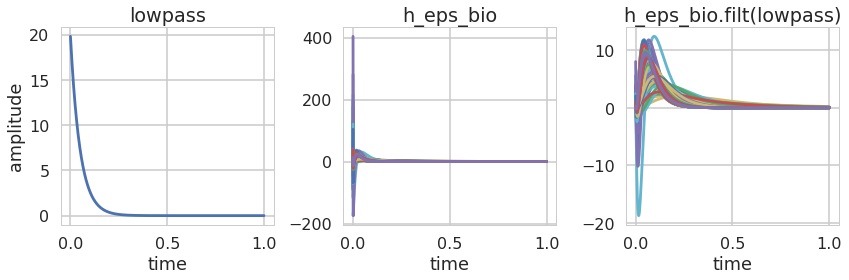

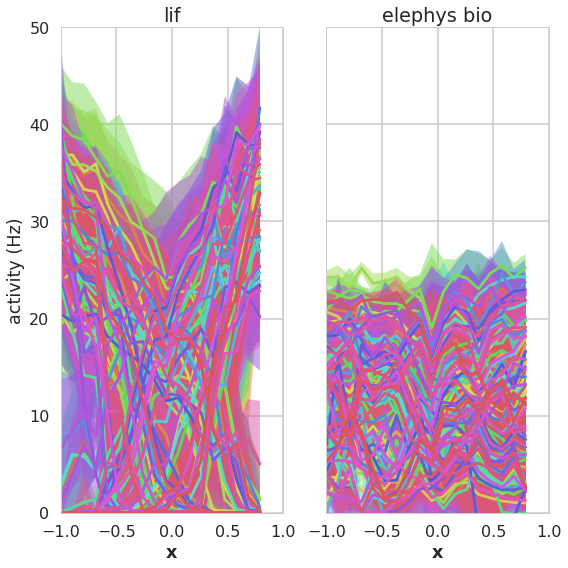

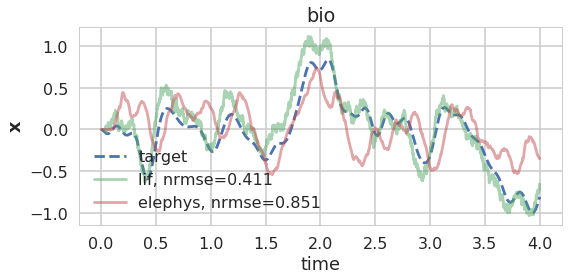

In [33]:
d_pre_u_load = np.load(save_dir+'decoders.npz')['d_pre_u']
d_pre_x_load = np.load(save_dir+'decoders.npz')['d_pre_x']
d_eps_bio_load = np.load(save_dir+'decoders.npz')['d_eps_bio']
d_eps_supv_load = np.load(save_dir+'decoders.npz')['d_eps_supv']

h_eps_bio_num = np.load(save_dir+'filters.npz')['h_eps_bio_num']
h_eps_bio_den = np.load(save_dir+'filters.npz')['h_eps_bio_den']
h_eps_supv_num = np.load(save_dir+'filters.npz')['h_eps_supv_num']
h_eps_supv_den = np.load(save_dir+'filters.npz')['h_eps_supv_den']

h_eps_bio_load = [LinearSystem((h_eps_bio_num[i], h_eps_bio_den[i])) for i in range(len(h_eps_bio_num))]
h_eps_supv_load = [LinearSystem((h_eps_supv_num[i], h_eps_supv_den[i])) for i in range(len(h_eps_supv_num))]


# h_eps_bio_load = LinearSystem((filts['h_eps_bio_num'], filts['h_eps_bio_den']))
# h_eps_supv_load = LinearSystem((filts['h_eps_supv_num'], filts['h_eps_supv_den']))

syn_weights_pre_u_supv_load = np.load(save_dir+'syn_weights.npz')['syn_weights_pre_u_supv']
syn_weights_pre_x_supv_load = np.load(save_dir+'syn_weights.npz')['syn_weights_pre_x_supv']
syn_weights_pre_u_bio_load = np.load(save_dir+'syn_weights.npz')['syn_weights_pre_u_bio']
syn_weights_supv_bio_load = np.load(save_dir+'syn_weights.npz')['syn_weights_supv_bio']
syn_weights_bio_bio_load = np.load(save_dir+'syn_weights.npz')['syn_weights_bio_bio']

syn_encoders_pre_u_supv_load = np.load(save_dir+'syn_encoders.npz')['syn_encoders_pre_u_supv']
syn_encoders_pre_x_supv_load = np.load(save_dir+'syn_encoders.npz')['syn_encoders_pre_x_supv']
syn_encoders_pre_u_bio_load = np.load(save_dir+'syn_encoders.npz')['syn_encoders_pre_u_bio']
syn_encoders_supv_bio_load = np.load(save_dir+'syn_encoders.npz')['syn_encoders_supv_bio']
syn_encoders_bio_bio_load = np.load(save_dir+'syn_encoders.npz')['syn_encoders_bio_bio']

print "training fb"
h_eps_dict_fb, d_eps_dict_fb, syn_encoders_dict_fb, syn_weights_dict_fb = bio_fb_double_opt(
    d_pre_u_load,
    d_pre_x_load,    
    d_eps_bio_load,
    d_eps_supv_load,
    h_eps_bio_load,
    h_eps_supv_load,
    syn_weights_pre_u_supv_load,
    syn_weights_pre_x_supv_load,
    syn_weights_pre_u_bio_load,
    syn_weights_supv_bio_load,
    syn_weights_bio_bio_load,
    syn_encoders_pre_u_supv_load,
    syn_encoders_pre_x_supv_load,
    syn_encoders_pre_u_bio_load,
    syn_encoders_supv_bio_load,
    syn_encoders_bio_bio_load,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    save_dir=save_dir,
    save_file_supv=save_file_supv,
    save_file_bio=save_file_bio,
    eta=eta,
    n_zeros=2,
    n_poles=2,
    z_min=1e1,
    z_max=1e3,
    p_min=-1e2,
    p_max=-1e0,
    learn_supv=False,
    learn_bio=False,
    learn_fb=True,
    optimize_supv=False,
    optimize_bio=True,
    plot_supv=False,
    plot_bio=True,
    sim_supv=False,
    sim_bio=True)

print "testing"
_, _, _, _ = bio_fb_double_opt(
    d_pre_u_load,
    d_pre_x_load,    
    d_eps_dict_fb['d_eps_bio'],
    d_eps_supv_load,
    h_eps_dict_fb['h_eps_bio'],
    h_eps_supv_load,
    syn_weights_pre_u_supv_load,
    syn_weights_pre_x_supv_load,
    syn_weights_dict_fb['syn_weights_pre_u_bio'],
    syn_encoders_supv_bio_load,
    syn_weights_dict_fb['syn_weights_bio_bio'],
    syn_encoders_pre_u_supv_load,
    syn_encoders_pre_x_supv_load,
    syn_encoders_dict_fb['syn_encoders_pre_u_bio'],
    syn_encoders_supv_bio_load,
    syn_encoders_dict_fb['syn_encoders_bio_bio'],
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    learn_supv=False,
    learn_bio=False,
    learn_fb=False,
    optimize_supv=False,
    optimize_bio=False,
    plot_supv=False,
    plot_bio=True,
    sim_supv=False,
    sim_bio=True)

print "testing"
freq_white_noise = freq
_, _, _, _ = bio_fb_double_opt(
    d_pre_u_load,
    d_pre_x_load,    
    d_eps_dict_fb['d_eps_bio'],
    d_eps_supv_load,
    h_eps_dict_fb['h_eps_bio'],
    h_eps_supv_load,
    syn_weights_pre_u_supv_load,
    syn_weights_pre_x_supv_load,
    syn_weights_dict_fb['syn_weights_pre_u_bio'],
    syn_encoders_supv_bio_load,
    syn_weights_dict_fb['syn_weights_bio_bio'],
    syn_encoders_pre_u_supv_load,
    syn_encoders_pre_x_supv_load,
    syn_encoders_dict_fb['syn_encoders_pre_u_bio'],
    syn_encoders_supv_bio_load,
    syn_encoders_dict_fb['syn_encoders_bio_bio'],
    t=4,
    freq=freq_white_noise,
    signal='white_noise',
    n_neurons=n_neurons,
    n_syn=n_syn,
    learn_supv=False,
    learn_bio=False,
    learn_fb=False,
    optimize_supv=False,
    optimize_bio=False,
    plot_supv=False,
    plot_bio=True,
    sim_supv=False,
    sim_bio=True)